## Statistical analysis of the MovieLens 1m dataset

Like Wan et al., we split a user's move preferences into (1) the user's willingness to consume (watch) a movie, and (2) the user's satisfaction feedback (rating) for the movie. 

The following analysis are purely observational and aim to identify bias across these two aspects. 



Code adapted from Wan et al.'s Github repository: https://github.com/MengtingWan/marketBias/blob/master/analysis.ipynb

In [16]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

%matplotlib inline
rc('pdf', fonttype=42)

Note to avoid modifying Wan et al.'s code significantly, we named the dataframe columns in the same way that they did. `model_attr` in our context is the gender stereotype of movie genres. Movie genres are gendered based on who is represented in certain kinds of movies and societal/cultural expectations of what males vs females should like (reinforced by various agents of socialization over people's lifetimes). 

In [9]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns) > 0:
        tab = tab[columns]
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expected = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expected market size')
    display((tab-expected).round(2))
    
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(
        ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3,
                      columns=['F-stat', 'p-value'], 
                      index=['product', 'user', 'product:user'])
    display(df.round(3))
    return df

def plot_avg_by_segment(df_review, metric, figsize, index=[], dataset='', dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./plot/'+dataset+'_'+metric+'_heatmap.pdf', bbox_inches='tight')

In [17]:
df_review = pd.read_csv('./data/df_movielens_1m.csv')
df_review['timestamp'] = df_review['timestamp'].apply(lambda d: datetime.fromtimestamp(d).strftime('%Y-%m-%d'))
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

Null hypothesis is that the gender stereotype of movies and user identity is statistically independent. Our Chi-Squared test shows that we will reject the null hypothesis with an extremely large Chi^2 and significant p-value. 

Contingency table of the frequency distribution of movie genre gender stereotypes and user identities confirms self-congruity (i.e. movies perceived as 'male' movies are watched by more male users). Again, please ignore `model_attr` which should be more like `movie_attr`

In [24]:
contingency_table(df_review)

contingency table


user_attr,F,M,All
model_attr,,,
F,109920,235355,345275
M,72279,318055,390334
MF,64241,200359,264600
All,246440,753769,1000209


chi2 17526.946 p-value 0.0

real market size - expected market size


user_attr,F,M
model_attr,,
F,24848.21,-24848.21
M,-23894.81,23894.81
MF,-953.40,953.40


User satisfaction as a function of movie genre and user identity, using 2-way analysis of variance (ANOVA). Rating scores = user satisfaction with the movie. 

Null hypotheses:
- `product`: average user satisfaction is equal across different movie genres
- `user`: average user satisfaction is equal across different user identity groups
- `product:user` no interact effect between movie genre and user groups w.r.t satisfaction

If the null hypothesis is satisfied, we would expect F-statistic (between-group variation / within-group variation) ... **TODO**

In [25]:
_ = two_way_anova(df_review, 'rating')

,F-stat,p-value
product,3915.611,0.0
user,69.454,0.0
product:user,48.329,0.0


Heatmap of sample means and their 95% confidence intervals. We find that ... **TODO**

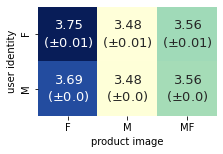

In [26]:
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], dataset, dump=False)